# L7: Klasyfikacja

Na dzisiejszych ćwiczeniach zajmiemy się klasyfikacją na przykładzie problemu przewidywania raka piersi. Przypomnimy sobie pojęcia omawiane na zajęciach: model evaluation, posterior/likelihood. 

Będziemy chcieli znaleźć optymalny model dla niestandardowych sytuacji klasyfikacyjnych (kiedy nie tylko accuracy jest najważniejsze).

In [90]:
import matplotlib.pylab as plt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import PCA
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV
import seaborn as sns
from sklearn.metrics import precision_score, recall_score
from sklearn.linear_model import LogisticRegression 
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB

# Metryki

Przypomnijmy, że zadaniem uczenia maszynowego jest znalezienie modelu, który minimalizuje loss na zbiorze testowym (notebooki L5 oraz L6). Tutaj zajmujemy się definicjami metryk, z których każda także może być funkcją kosztu.

<img width=300 src="wyklady2017/mum_figures/precision_recall.png">

Niech $y$ to prawdziwa klasa, a $\hat{y}$ to predykcja. Najpopularniejsze metryki dla klasyfikatorów binarnych:

* Accuracy

$ \frac{TP + TN}{TN + FN + TP + FP} = p(\hat{y} = y | x) $

* Precision 

$ \frac{TP}{TP + FP} = p(y=1| \hat{y} =1) $

* Recall 

$ \frac{TP}{TP + FN} = p(\hat{y}=1| y =1) $

## Bardziej zaawansowane metryki

Kolejne metryki (dla klasyfikatorów binarnych) będą oparte o confusion matrix:

<img src="figures/L7/confusion_matrix.png">

TODO: Wpisać F1 i MCC. Jakie są różnice?

## Funkcja kosztu

Na podstawie confusion matrix możemy definiować funkcję kosztu. Ile płacimy za FN? W przypadku klasyfikacji raka, dużo "tańsze" jest skierowanie pacjenta na dodatkowe badania niż postawienie fałszywej negatywnej diagnozy!

<img width=400 src="figures/L7/cost_mat.png">

Oczywiście zazwyczaj $C_{TP}$ oraz $C_{TN}$ jest 0. Funkcja kosztu 0-1 (albo accuracy) odtwarza $C_{FN} = C_{FP}$.

# Klasyfikacja wrażliwa na koszt

Ref: http://web.cs.iastate.edu/~honavar/elkan.pdf

Czasami jesteśmy bardziej zainteresowani w precision lub recall. Są to problemy ``cost-sensitive``.

In [28]:
data = pd.read_csv("/Users/kudkudak/Downloads/data.csv")
data.drop("Unnamed: 32",axis=1,inplace=True)
data['diagnosis']=data['diagnosis'].map({'M':1,'B':0})
data.describe() 

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,3.037183e+07,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,1.250206e+08,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,8.670000e+03,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,8.692180e+05,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,9.060240e+05,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,8.813129e+06,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,9.113205e+08,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


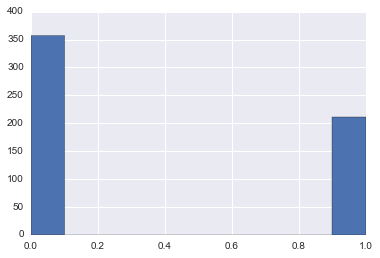

In [32]:
data['diagnosis'].hist()

In [122]:
# Wybieramy cechy
prediction_var = ['texture_mean','perimeter_mean','smoothness_mean','compactness_mean','symmetry_mean']
train, test = train_test_split(data, test_size = 0.3)# in this our main data is splitted into train and test
train_X = train[prediction_var][0:100]
train_y=train.diagnosis[0:100]
test_X= test[prediction_var] 
test_y =test.diagnosis  

In [125]:
# Regresja logistyczna
model = LogisticRegression(C=1)
model.fit(train_X,train_y)
pred = model.predict(test_X)
print metrics.accuracy_score(pred, test_y)
print metrics.precision_score(pred, test_y)
print metrics.recall_score(pred, test_y)

0.853801169591
0.645161290323
0.93023255814


## Zadanie 1 [3 pkt]

1. Powyższy model ma istotnie wyższy recall niż precision. 

Zdefiniujmy jako model probabilistyczny model, który zwraca p($\hat{y}$ | y). Obiekt LogisticRegression zwraca tą wartość funkcją ``predict_proba``

1. Każdy model probabilistyczny można użyć do stworzenia klasyfikora, która może mieć precision 100% lub recall 100% trywialnie, jak? 

2. Krzywa precision/recall jest obliczana licząc precision oraz recall modelu probabilistycznego dla różnych wartości precision. Zarysuj wykres precision/recall dla modelu powyżej.

Powinno wyjść:

<img src="figures/L7/prec_recall.png">

# Zadanie 2 [3 pkt]

Założmy, że $C_{FP}$ = 1 i $C_{FN}$ = 10, co odpowiada sytuacji w której nie przejmujemy się postawieniem fałszywej pozytywnej diagnozy.

Według http://web.cs.iastate.edu/~honavar/elkan.pdf wystarczy w takim wypadku dodać wagi przykładom odpowiedniom wage.

* Przetestuj pare wag klasy negatywnej przez podanie argumentu class_weight do LogisticRegression. Dla każdej wartości wagi narysuj dokładność (accuracy) oraz wynik metryki FN_aversive. Powinno wyjść:

<img src="figures/L7/fn_aversive.png">

* Równoważnym sposobem tworzenia "cost-sensitive" klasyfikatora z modelu probabilistycznego jest zmiana progu (patrz Zadanie 1). Znajdź taki próg, aby wynik klasyfikatora z tym progiem był równoważny argumentowi class_weight.

Podpowiedź: Jeśli 2 sprawia problem, przejrzyj załączoną publikację

In [127]:
def FN_aversive(y_true, y_pred):
    FN = sum((y_true == 1) * (y_pred != y_true))
    FP = sum((y_true == 0) * (y_pred != y_true))
    return 10 * FN + FP

# Naive Bayes vs Regresja Logistyczna 

Ref: https://ai.stanford.edu/~ang/papers/nips01-discriminativegenerative.pdf

In [ ]:
# Naive Bayes
model = GaussianNB()
model.fit(train_X,train_y)
pred = model.predict(test_X)
print metrics.accuracy_score(pred, test_y)
print metrics.precision_score(pred, test_y)
print metrics.recall_score(pred, test_y)

## Wyprowadzenie

## Różnice

* Naive Bayes zakłada niezależność cech (brak korekty liniowych zależności)

* Naive Bayes to *model generatywny*, a *regresja logistyczna* to model dyskryminatywny.

## Zadanie 3 [3 pkt]

Zilustruj na przykładzie problem "double counting" w modelu Naive Bayes na przykładzie klasyfikatora SPAMu